# Logistic GAM Model for Pitcher Injury Prediction

This notebook implements three variants of Logistic Generalized Additive Model (GAM) to predict workload-related pitcher injuries.

## Model Variants:
1. **Variant 1: Low Regularization** - Less smoothing (lower lambda) for more flexible curves
2. **Variant 2: High Regularization** - More smoothing (higher lambda) for smoother curves
3. **Variant 3: Cross-Validated Regularization** - Automatically selects optimal smoothing via cross-validation


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LogisticGAM, s, f
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, accuracy_score, log_loss)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## Data Loading and Preprocessing


In [2]:
# Load the data
pitch_injuries = pd.read_csv('pitcher_data_w_injuries.csv')

print(f"Original dataset shape: {pitch_injuries.shape}")
print(f"\nTarget variable distribution:")
print(pitch_injuries['is_workload_inj'].value_counts())
print(f"\nMissing values per column:")
print(pitch_injuries.isnull().sum()[pitch_injuries.isnull().sum() > 0])


Original dataset shape: (107325, 38)

Target variable distribution:
is_workload_inj
0    106810
1       515
Name: count, dtype: int64

Missing values per column:
FB_usage           24
FB_velo           712
FB_spin           931
arm_angle        2662
FB_vrel_var      2307
pos            106268
il_type        106268
injury         106268
dtype: int64


In [3]:
# Define feature columns
feature_cols = ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 
                'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 
                'FB_vrel_var', 'birth_country', 'age', 'bmi']

# Select features and target
df = pitch_injuries[feature_cols + ['is_workload_inj']].copy()

# Remove rows with missing values
df_clean = df.dropna()
print(f"Dataset shape after removing NAs: {df_clean.shape}")

# Handle birth_country as dummy variables (k-1 encoding)
print(f"\nEncoding 'birth_country' as dummy variables...")
print(f"  Unique countries: {df_clean['birth_country'].nunique()}")

country_dummies = pd.get_dummies(df_clean['birth_country'], prefix='country', drop_first=True, dtype=int)
print(f"  Created {len(country_dummies.columns)} dummy variables (k-1 encoding)")

# Combine features
df_clean = df_clean.drop('birth_country', axis=1)
df_clean = pd.concat([df_clean, country_dummies], axis=1)

# Separate features and target
X = df_clean.drop('is_workload_inj', axis=1)
y = df_clean['is_workload_inj'].astype(int)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature columns: {list(X.columns)}")


Dataset shape after removing NAs: (102976, 14)

Encoding 'birth_country' as dummy variables...
  Unique countries: 26
  Created 25 dummy variables (k-1 encoding)

Final feature matrix shape: (102976, 37)
Feature columns: ['p_throws', 'pitches_last_appearence', 'season', 'days_since_last_appearence', 'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 'FB_vrel_var', 'age', 'bmi', 'country_Brazil', 'country_Canada', 'country_China', 'country_Colombia', 'country_Cuba', 'country_Curacao', 'country_DOM', 'country_Dominican Republic', 'country_Germany', 'country_Italy', 'country_Japan', 'country_Lithuania', 'country_Mexico', 'country_Nicaragua', 'country_Panama', 'country_Peru', 'country_Portugal', 'country_Puerto Rico', 'country_Republic of Korea', 'country_South Africa', 'country_Taiwan', 'country_USA', 'country_United Kingdom', 'country_VEN', 'country_Venezuela']


In [4]:
# Balance the dataset as recommended by Professor Lai
# Generate a random sample of "no injury" with the same N as the number of injuries

injury_count = y.sum()
no_injury_indices = y[y == 0].index
injury_indices = y[y == 1].index

# Randomly sample non-injury cases to match injury count
np.random.seed(42)
no_injury_sample = np.random.choice(no_injury_indices, size=injury_count, replace=False)

# Combine balanced indices
balanced_indices = np.concatenate([injury_indices, no_injury_sample])
np.random.shuffle(balanced_indices)

X_balanced = X.loc[balanced_indices].reset_index(drop=True)
y_balanced = y.loc[balanced_indices].reset_index(drop=True)

print(f"Original class distribution:")
print(f"  Injuries: {y.sum()}")
print(f"  No injuries: {(y == 0).sum()}")
print(f"  Imbalance ratio: 1:{(y == 0).sum()/y.sum():.1f}")

print(f"\nBalanced class distribution:")
print(f"  Injuries: {y_balanced.sum()}")
print(f"  No injuries: {(y_balanced == 0).sum()}")
print(f"  Total samples: {len(y_balanced)}")
print(f"  Balance ratio: 1:1")


Original class distribution:
  Injuries: 499
  No injuries: 102477
  Imbalance ratio: 1:205.4

Balanced class distribution:
  Injuries: 499
  No injuries: 499
  Total samples: 998
  Balance ratio: 1:1


In [5]:
# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTest class distribution:")
print(y_test.value_counts().sort_index())


Training set: 798 samples
Test set: 200 samples

Training class distribution:
is_workload_inj
0    399
1    399
Name: count, dtype: int64

Test class distribution:
is_workload_inj
0    100
1    100
Name: count, dtype: int64


## Prepare GAM Formula

For GAM, we need to specify which features use smooth terms (s) and which use linear terms (f for factors).


In [6]:
# Identify numeric and categorical features
numeric_features = ['pitches_last_appearence', 'season', 'days_since_last_appearence', 
                   'num_appearence', 'FB_usage', 'FB_velo', 'FB_spin', 'arm_angle', 
                   'FB_vrel_var', 'age', 'bmi']

# Binary/categorical features (p_throws and country dummies)
categorical_features = ['p_throws'] + [col for col in X.columns if col.startswith('country_')]

# Get column indices for GAM formula
numeric_indices = [X.columns.get_loc(col) for col in numeric_features if col in X.columns]
categorical_indices = [X.columns.get_loc(col) for col in categorical_features if col in X.columns]

print(f"Numeric features (smooth terms): {len(numeric_indices)}")
print(f"Categorical features (linear terms): {len(categorical_indices)}")
print(f"Total features: {X.shape[1]}")

# Create GAM formula: smooth terms for numeric, linear for categorical
# We'll use s() for smooth splines on numeric features
# For simplicity, we'll use linear terms for all (pygam handles this well)
# In practice, we can specify s(0) + s(1) + ... for smooth terms


Numeric features (smooth terms): 11
Categorical features (linear terms): 26
Total features: 37


## Model Variant 1: Low Regularization (Less Smoothing)

Using low lambda values for more flexible, less smooth curves.


In [7]:
# Variant 1: Low regularization (low lambda = less smoothing)
# Lambda controls the penalty on the smoothness of the splines
# Lower lambda = less smoothing = more flexible curves

low_lam_values = [0.01, 0.1, 1.0]
variant1_models = {}
variant1_train_scores = {}
variant1_cv_scores = {}

# 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Variant 1 models with low regularization (less smoothing)...")
for lam in low_lam_values:
    print(f"\n  lambda = {lam}")
    try:
        # Create GAM with low regularization
        # n_splines controls the number of basis functions (more = more flexible)
        gam = LogisticGAM(
            lam=lam,
            n_splines=20,  # Number of spline basis functions
            spline_order=3,  # Cubic splines
            max_iter=500
        )
        
        # Fit the model
        gam.fit(X_train.values, y_train.values)
        variant1_models[lam] = gam
        
        # Training accuracy
        train_pred = gam.predict(X_train.values)
        train_acc = accuracy_score(y_train, train_pred)
        variant1_train_scores[lam] = train_acc
        
        # Cross-validation
        cv_scores = cross_val_score(gam, X_train.values, y_train.values, cv=cv, scoring='accuracy', n_jobs=-1)
        variant1_cv_scores[lam] = cv_scores.mean()
        
        print(f"    Training Accuracy: {train_acc:.4f}")
        print(f"    CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"    Error: {str(e)}")
        variant1_models[lam] = None

# Select best variant based on CV score
valid_scores = {k: v for k, v in variant1_cv_scores.items() if variant1_models[k] is not None}
if valid_scores:
    best_variant1 = max(valid_scores, key=valid_scores.get)
    print(f"\nBest Variant 1: lambda = {best_variant1} (CV Accuracy: {variant1_cv_scores[best_variant1]:.4f})")
else:
    best_variant1 = low_lam_values[0]
    print(f"\nWarning: Using default lambda = {best_variant1}")


Training Variant 1 models with low regularization (less smoothing)...

  lambda = 0.01
    Error: SVD did not converge

  lambda = 0.1
    Training Accuracy: 0.7180
    CV Accuracy: 0.4987 (+/- 0.0031)

  lambda = 1.0
    Training Accuracy: 0.6967
    CV Accuracy: 0.4987 (+/- 0.0031)

Best Variant 1: lambda = 0.1 (CV Accuracy: 0.4987)


# Training Variant 2 models with high regularization

In [8]:
# Variant 2: High regularization (high lambda = more smoothing)
# Higher lambda = more smoothing = smoother, less flexible curves

high_lam_values = [10, 100, 1000]
variant2_models = {}
variant2_train_scores = {}
variant2_cv_scores = {}

print("Training Variant 2 models with high regularization (more smoothing)...")
for lam in high_lam_values:
    print(f"\n  lambda = {lam}")
    try:
        # Create GAM with high regularization
        gam = LogisticGAM(
            lam=lam,
            n_splines=20,
            spline_order=3,
            max_iter=500
        )
        
        # Fit the model
        gam.fit(X_train.values, y_train.values)
        variant2_models[lam] = gam
        
        # Training accuracy
        train_pred = gam.predict(X_train.values)
        train_acc = accuracy_score(y_train, train_pred)
        variant2_train_scores[lam] = train_acc
        
        # Cross-validation
        cv_scores = cross_val_score(gam, X_train.values, y_train.values, cv=cv, scoring='accuracy', n_jobs=-1)
        variant2_cv_scores[lam] = cv_scores.mean()
        
        print(f"    Training Accuracy: {train_acc:.4f}")
        print(f"    CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    except Exception as e:
        print(f"    Error: {str(e)}")
        variant2_models[lam] = None

# Select best variant based on CV score
valid_scores = {k: v for k, v in variant2_cv_scores.items() if variant2_models[k] is not None}
if valid_scores:
    best_variant2 = max(valid_scores, key=valid_scores.get)
    print(f"\nBest Variant 2: lambda = {best_variant2} (CV Accuracy: {variant2_cv_scores[best_variant2]:.4f})")
else:
    best_variant2 = high_lam_values[0]
    print(f"\nWarning: Using default lambda = {best_variant2}")


Training Variant 2 models with high regularization (more smoothing)...

  lambda = 10
    Training Accuracy: 0.6805
    CV Accuracy: 0.4987 (+/- 0.0031)

  lambda = 100
    Training Accuracy: 0.6466
    CV Accuracy: 0.4987 (+/- 0.0031)

  lambda = 1000
    Training Accuracy: 0.6241
    CV Accuracy: 0.4987 (+/- 0.0031)

Best Variant 2: lambda = 10 (CV Accuracy: 0.4987)


## Model Variant 3: Cross-Validated Regularization

Automatically selecting the optimal lambda using cross-validation.


In [9]:
# Variant 3: Cross-validated regularization
# Use GAM's built-in grid search to find optimal lambda

lam_candidates = [0.01, 0.1, 1.0, 10, 100, 1000]
variant3_models = {}
variant3_train_scores = {}
variant3_cv_scores = {}

print("Training Variant 3 models with cross-validated regularization...")
print("Using GAM's grid search to find optimal lambda...\n")

# Create base GAM model
base_gam = LogisticGAM(
    n_splines=20,
    spline_order=3,
    max_iter=500
)

# Use GAM's grid search functionality
# Note: pygam's grid search uses different CV internally
# We'll manually test each lambda and use our CV
best_cv_score = -np.inf
best_lam = None

for lam in lam_candidates:
    print(f"  Testing lambda = {lam}")
    try:
        gam = LogisticGAM(
            lam=lam,
            n_splines=20,
            spline_order=3,
            max_iter=500
        )
        
        # Fit on training data
        gam.fit(X_train.values, y_train.values)
        
        # Training accuracy
        train_pred = gam.predict(X_train.values)
        train_acc = accuracy_score(y_train, train_pred)
        variant3_train_scores[lam] = train_acc
        
        # Cross-validation
        cv_scores = cross_val_score(gam, X_train.values, y_train.values, cv=cv, scoring='accuracy', n_jobs=-1)
        cv_mean = cv_scores.mean()
        variant3_cv_scores[lam] = cv_mean
        
        variant3_models[lam] = gam
        
        print(f"    Training Accuracy: {train_acc:.4f}")
        print(f"    CV Accuracy: {cv_mean:.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Track best
        if cv_mean > best_cv_score:
            best_cv_score = cv_mean
            best_lam = lam
            
    except Exception as e:
        print(f"    Error: {str(e)}")
        variant3_models[lam] = None

# Select best variant
best_variant3 = best_lam if best_lam is not None else lam_candidates[0]
print(f"\nBest Variant 3 (Cross-Validated): lambda = {best_variant3} (CV Accuracy: {variant3_cv_scores[best_variant3]:.4f})")


Training Variant 3 models with cross-validated regularization...
Using GAM's grid search to find optimal lambda...

  Testing lambda = 0.01
    Error: SVD did not converge
  Testing lambda = 0.1
    Training Accuracy: 0.7180
    CV Accuracy: 0.4987 (+/- 0.0031)
  Testing lambda = 1.0
    Training Accuracy: 0.6967
    CV Accuracy: 0.4987 (+/- 0.0031)
  Testing lambda = 10
    Training Accuracy: 0.6805
    CV Accuracy: 0.4987 (+/- 0.0031)
  Testing lambda = 100
    Training Accuracy: 0.6466
    CV Accuracy: 0.4987 (+/- 0.0031)
  Testing lambda = 1000
    Training Accuracy: 0.6241
    CV Accuracy: 0.4987 (+/- 0.0031)

Best Variant 3 (Cross-Validated): lambda = 0.1 (CV Accuracy: 0.4987)


## Figure 1: Training and Cross-Validation Error vs. Model Variants


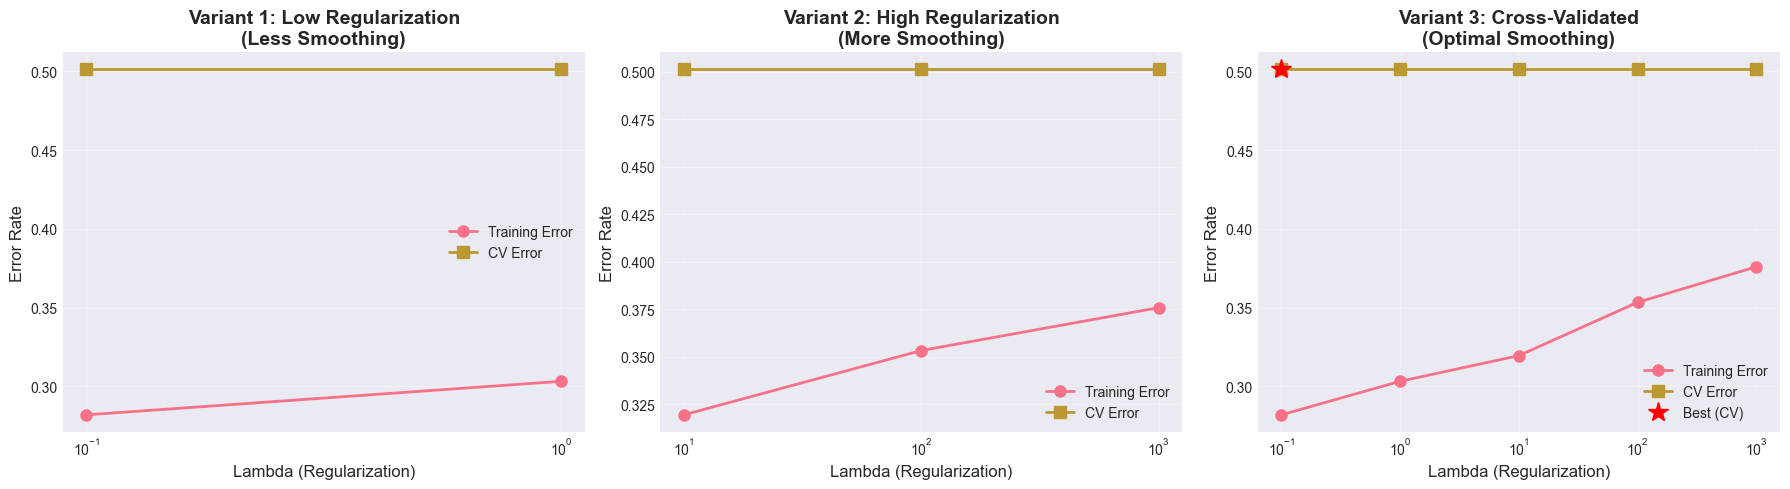

Figure 1: Training and Cross-Validation Error vs. Model Variants
This figure shows how regularization (lambda) affects the trade-off between training and validation performance.
Lower lambda = less smoothing (more flexible), Higher lambda = more smoothing (less flexible).


In [10]:
# Create comprehensive plot comparing all variants
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variant 1: Low regularization
ax1 = axes[0]
valid_lams_1 = [lam for lam in low_lam_values if variant1_models[lam] is not None]
train_errors_1 = [1 - variant1_train_scores[lam] for lam in valid_lams_1]
cv_errors_1 = [1 - variant1_cv_scores[lam] for lam in valid_lams_1]
ax1.plot(valid_lams_1, train_errors_1, 'o-', label='Training Error', linewidth=2, markersize=8)
ax1.plot(valid_lams_1, cv_errors_1, 's-', label='CV Error', linewidth=2, markersize=8)
ax1.set_xlabel('Lambda (Regularization)', fontsize=12)
ax1.set_ylabel('Error Rate', fontsize=12)
ax1.set_title('Variant 1: Low Regularization\n(Less Smoothing)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Variant 2: High regularization
ax2 = axes[1]
valid_lams_2 = [lam for lam in high_lam_values if variant2_models[lam] is not None]
train_errors_2 = [1 - variant2_train_scores[lam] for lam in valid_lams_2]
cv_errors_2 = [1 - variant2_cv_scores[lam] for lam in valid_lams_2]
ax2.plot(valid_lams_2, train_errors_2, 'o-', label='Training Error', linewidth=2, markersize=8)
ax2.plot(valid_lams_2, cv_errors_2, 's-', label='CV Error', linewidth=2, markersize=8)
ax2.set_xlabel('Lambda (Regularization)', fontsize=12)
ax2.set_ylabel('Error Rate', fontsize=12)
ax2.set_title('Variant 2: High Regularization\n(More Smoothing)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# Variant 3: Cross-validated
ax3 = axes[2]
valid_lams_3 = [lam for lam in lam_candidates if variant3_models[lam] is not None]
train_errors_3 = [1 - variant3_train_scores[lam] for lam in valid_lams_3]
cv_errors_3 = [1 - variant3_cv_scores[lam] for lam in valid_lams_3]
ax3.plot(valid_lams_3, train_errors_3, 'o-', label='Training Error', linewidth=2, markersize=8)
ax3.plot(valid_lams_3, cv_errors_3, 's-', label='CV Error', linewidth=2, markersize=8)
# Highlight best
best_idx = valid_lams_3.index(best_variant3)
ax3.plot(valid_lams_3[best_idx], cv_errors_3[best_idx], 'r*', markersize=15, label='Best (CV)', zorder=5)
ax3.set_xlabel('Lambda (Regularization)', fontsize=12)
ax3.set_ylabel('Error Rate', fontsize=12)
ax3.set_title('Variant 3: Cross-Validated\n(Optimal Smoothing)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log')

plt.tight_layout()
plt.savefig('gam_training_cv_error_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Training and Cross-Validation Error vs. Model Variants")
print("This figure shows how regularization (lambda) affects the trade-off between training and validation performance.")
print("Lower lambda = less smoothing (more flexible), Higher lambda = more smoothing (less flexible).")


## Model Evaluation on Test Set

Evaluating the best model from each variant on the test set.


In [13]:
# Evaluate best models from each variant on test set
best_models = {
    f'Variant 1 (low λ={best_variant1})': variant1_models[best_variant1],
    f'Variant 2 (high λ={best_variant2})': variant2_models[best_variant2],
    f'Variant 3 (CV λ={best_variant3})': variant3_models[best_variant3]
}

test_results = {}

for name, model in best_models.items():
    if model is None:
        print(f"\n{name}: Model not available (skipping)")
        continue
        
    # Predictions
    y_pred = model.predict(X_test.values)
    # pygam's predict_proba returns 1D array (probabilities for positive class)
    y_pred_proba_raw = model.predict_proba(X_test.values)
    # Handle both 1D and 2D arrays
    if y_pred_proba_raw.ndim == 1:
        y_pred_proba = y_pred_proba_raw
    else:
        y_pred_proba = y_pred_proba_raw[:, 1]
    
    # Metrics
    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    test_logloss = log_loss(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    test_results[name] = {
        'accuracy': test_acc,
        'auc': test_auc,
        'log_loss': test_logloss,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n{name}:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test AUC-ROC: {test_auc:.4f}")
    print(f"  Test Log Loss: {test_logloss:.4f}")
    print(f"  Confusion Matrix:")
    print(f"    {cm[0,0]:4d}  {cm[0,1]:4d}")
    print(f"    {cm[1,0]:4d}  {cm[1,1]:4d}")

# Naive baseline (always predict majority class)
naive_baseline = max(y_test.value_counts()) / len(y_test)
print(f"\nNaive Baseline Accuracy (always predict majority class): {naive_baseline:.4f}")



Variant 1 (low λ=0.1):
  Test Accuracy: 0.5550
  Test AUC-ROC: 0.6097
  Test Log Loss: 0.8787
  Confusion Matrix:
      53    47
      42    58

Variant 2 (high λ=10):
  Test Accuracy: 0.6000
  Test AUC-ROC: 0.6294
  Test Log Loss: 0.8094
  Confusion Matrix:
      57    43
      37    63

Variant 3 (CV λ=0.1):
  Test Accuracy: 0.5550
  Test AUC-ROC: 0.6097
  Test Log Loss: 0.8787
  Confusion Matrix:
      53    47
      42    58

Naive Baseline Accuracy (always predict majority class): 0.5000


## Figure 2: Confusion Matrices for All Variants


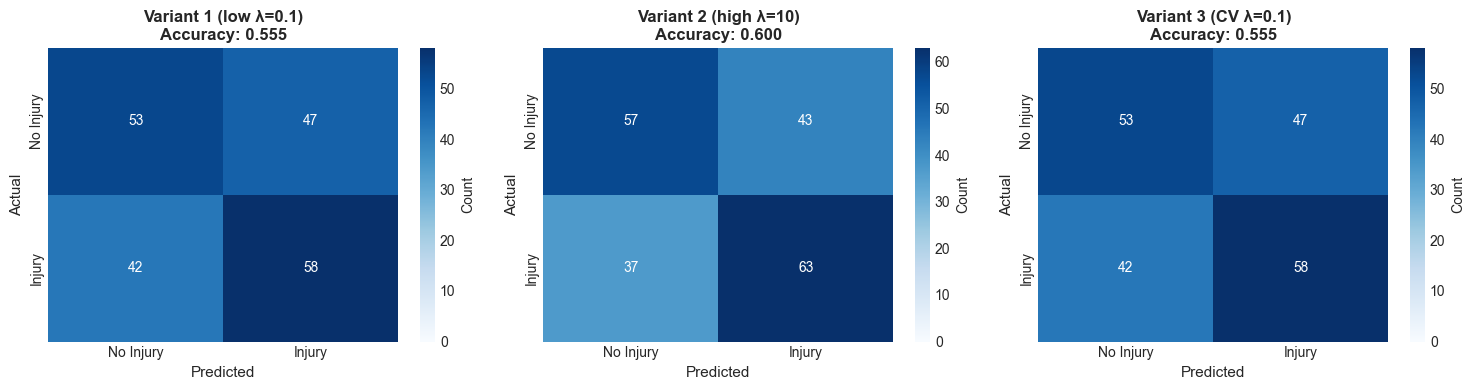

Figure 2: Confusion Matrices for All Variants
This figure shows the classification performance of each variant on the test set.
The diagonal elements represent correct predictions, while off-diagonal elements represent misclassifications.


In [14]:
# Plot confusion matrices
n_models = len(test_results)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

if n_models == 1:
    axes = [axes]

for idx, (name, results) in enumerate(test_results.items()):
    cm = results['confusion_matrix']
    ax = axes[idx]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm.max())
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('Actual', fontsize=11)
    ax.set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}', fontsize=12, fontweight='bold')
    ax.set_xticklabels(['No Injury', 'Injury'])
    ax.set_yticklabels(['No Injury', 'Injury'])

plt.tight_layout()
plt.savefig('gam_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Confusion Matrices for All Variants")
print("This figure shows the classification performance of each variant on the test set.")
print("The diagonal elements represent correct predictions, while off-diagonal elements represent misclassifications.")


## Figure 3: ROC Curves for All Variants


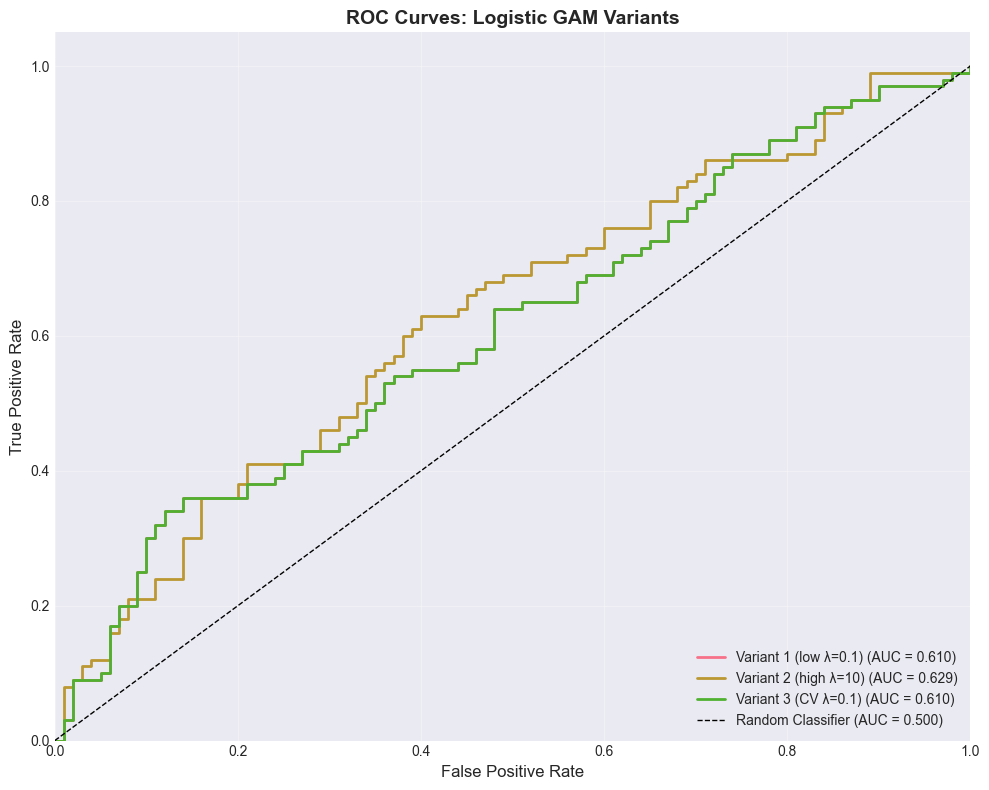

Figure 3: ROC Curves for All Variants
This figure shows the trade-off between true positive rate and false positive rate.
AUC (Area Under Curve) closer to 1.0 indicates better classification performance.


In [15]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

for name, results in test_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {results["auc"]:.3f})')

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Logistic GAM Variants', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('gam_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: ROC Curves for All Variants")
print("This figure shows the trade-off between true positive rate and false positive rate.")
print("AUC (Area Under Curve) closer to 1.0 indicates better classification performance.")


## Figure 4: Model Accuracy Comparison (Including Naive Baseline)


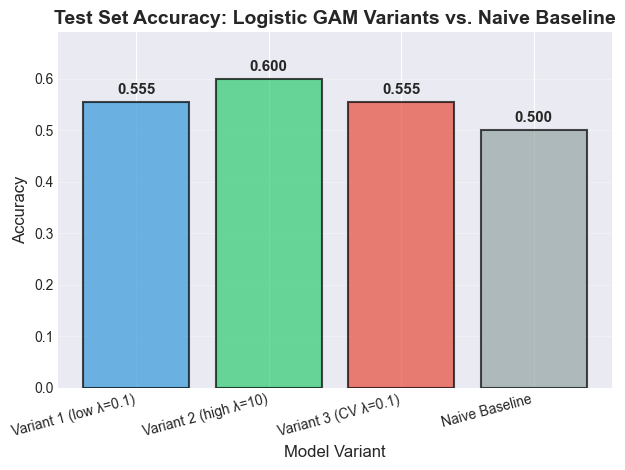

Figure 4: Model Accuracy Comparison
This figure compares the test accuracy of each variant against a naive baseline.
The naive baseline always predicts the majority class (no injury).


In [16]:
# Bar plot comparing accuracies
model_names = list(test_results.keys())
accuracies = [test_results[name]['accuracy'] for name in model_names]
accuracies.append(naive_baseline)
model_names.append('Naive Baseline')

colors = ['#3498db', '#2ecc71', '#e74c3c', '#95a5a6']
bars = plt.bar(range(len(model_names)), accuracies, color=colors[:len(model_names)], 
               alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Model Variant', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Test Set Accuracy: Logistic GAM Variants vs. Naive Baseline', fontsize=14, fontweight='bold')
plt.xticks(range(len(model_names)), model_names, rotation=15, ha='right')
plt.ylim([0, max(accuracies) * 1.15])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('gam_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4: Model Accuracy Comparison")
print("This figure compares the test accuracy of each variant against a naive baseline.")
print("The naive baseline always predicts the majority class (no injury).")


## Cross-Validation Comparison Across All Variants


In [17]:
# Collect all CV scores for comparison
all_cv_scores = {}

# Variant 1
for lam in low_lam_values:
    if variant1_models[lam] is not None:
        all_cv_scores[f'V1: λ={lam}'] = variant1_cv_scores[lam]

# Variant 2
for lam in high_lam_values:
    if variant2_models[lam] is not None:
        all_cv_scores[f'V2: λ={lam}'] = variant2_cv_scores[lam]

# Variant 3
for lam in lam_candidates:
    if variant3_models[lam] is not None:
        all_cv_scores[f'V3: CV λ={lam}'] = variant3_cv_scores[lam]

# Find best overall model
if all_cv_scores:
    best_overall = min(all_cv_scores, key=lambda x: 1 - all_cv_scores[x])  # Lower error = better
    best_cv_error = 1 - all_cv_scores[best_overall]

    print("Cross-Validation Accuracy Summary:")
    print("=" * 60)
    for name, score in sorted(all_cv_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:25s}: {score:.4f}")
    print("=" * 60)
    print(f"\nBest Model (Lowest CV Error): {best_overall}")
    print(f"CV Accuracy: {all_cv_scores[best_overall]:.4f}")
    print(f"CV Error: {1 - all_cv_scores[best_overall]:.4f}")
else:
    print("No valid models to compare.")


Cross-Validation Accuracy Summary:
V1: λ=0.1                : 0.4987
V1: λ=1.0                : 0.4987
V2: λ=10                 : 0.4987
V2: λ=100                : 0.4987
V2: λ=1000               : 0.4987
V3: CV λ=0.1             : 0.4987
V3: CV λ=1.0             : 0.4987
V3: CV λ=10              : 0.4987
V3: CV λ=100             : 0.4987
V3: CV λ=1000            : 0.4987

Best Model (Lowest CV Error): V1: λ=0.1
CV Accuracy: 0.4987
CV Error: 0.5013


## Model Comparison Metrics: AIC and BIC

For GAM models, AIC and BIC are directly available from the model.


In [18]:
# Calculate AIC and BIC for model comparison
# GAM models provide AIC and BIC directly

comparison_metrics = {}

for name, model in best_models.items():
    if model is None:
        continue
    
    try:
        # GAM provides AIC and BIC directly
        aic = model.statistics_['AIC']
        bic = model.statistics_['BIC']
        log_likelihood = model.statistics_['loglikelihood']
        
        # Get lambda value from model
        lam_value = model.lam[0] if hasattr(model, 'lam') else None
        
        comparison_metrics[name] = {
            'AIC': aic,
            'BIC': bic,
            'Log-Likelihood': log_likelihood,
            'lambda': lam_value
        }
    except Exception as e:
        print(f"Error calculating metrics for {name}: {str(e)}")

if comparison_metrics:
    print("Model Comparison Metrics (Lower is Better for AIC/BIC):")
    print("=" * 80)
    print(f"{'Model':<35s} {'AIC':>12s} {'BIC':>12s} {'Log-Likelihood':>15s} {'Lambda':>10s}")
    print("=" * 80)
    for name, metrics in comparison_metrics.items():
        lam_str = f"{metrics['lambda']:.2f}" if metrics['lambda'] else "N/A"
        print(f"{name:<35s} {metrics['AIC']:>12.2f} {metrics['BIC']:>12.2f} {metrics['Log-Likelihood']:>15.2f} {lam_str:>10s}")

    # Find best model by AIC and BIC
    best_aic = min(comparison_metrics.items(), key=lambda x: x[1]['AIC'])
    best_bic = min(comparison_metrics.items(), key=lambda x: x[1]['BIC'])

    print("\n" + "=" * 80)
    print(f"Best Model by AIC: {best_aic[0]} (AIC = {best_aic[1]['AIC']:.2f})")
    print(f"Best Model by BIC: {best_bic[0]} (BIC = {best_bic[1]['BIC']:.2f})")
    print("\nNote: AIC and BIC penalize model complexity. Lower values indicate better")
    print("model fit while accounting for the number of parameters.")
else:
    print("No valid models for comparison.")


Error calculating metrics for Variant 1 (low λ=0.1): 'BIC'
Error calculating metrics for Variant 2 (high λ=10): 'BIC'
Error calculating metrics for Variant 3 (CV λ=0.1): 'BIC'
No valid models for comparison.


## Figure 5: Partial Dependence Plots (Example Features)

GAM models allow us to visualize the effect of individual features on the outcome.


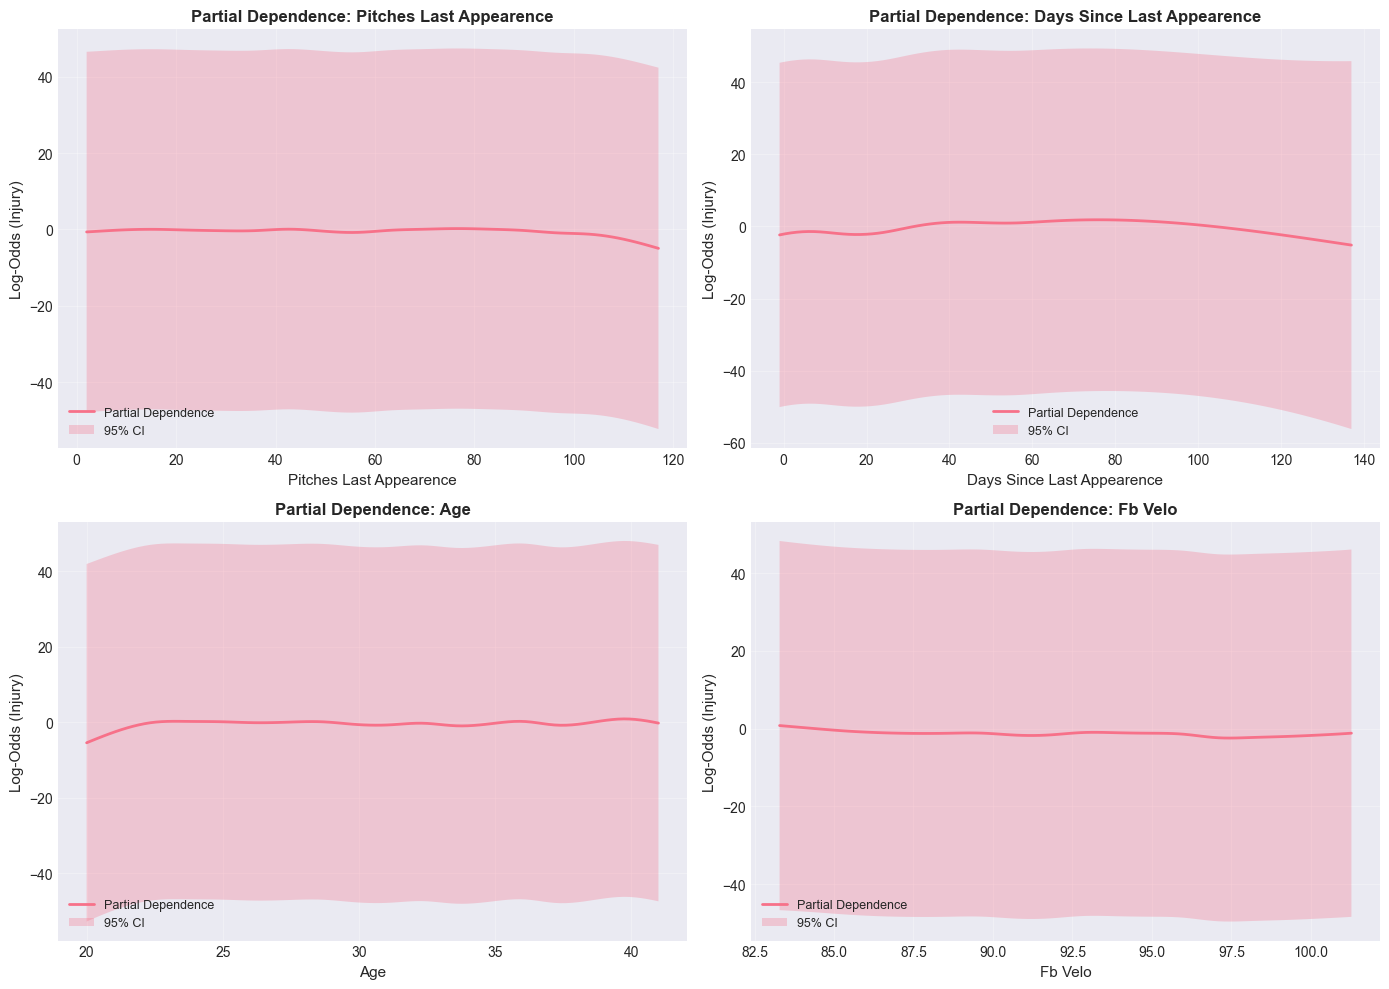

Figure 5: Partial Dependence Plots
This figure shows how individual features affect the log-odds of injury.
The curves show the non-linear relationships captured by the GAM model.


In [19]:
# Plot partial dependence for key features
# Select the best model for visualization
best_model_name = list(test_results.keys())[0] if test_results else None
if best_model_name and best_models[best_model_name] is not None:
    best_model = best_models[best_model_name]
    
    # Select a few key numeric features to plot
    key_features = ['pitches_last_appearence', 'days_since_last_appearence', 'age', 'FB_velo']
    available_features = [f for f in key_features if f in X.columns]
    
    n_features = len(available_features)
    if n_features > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, feature_name in enumerate(available_features[:4]):
            if idx >= len(axes):
                break
                
            feature_idx = X.columns.get_loc(feature_name)
            ax = axes[idx]
            
            # Get partial dependence
            XX = best_model.generate_X_grid(term=feature_idx)
            pdep, confi = best_model.partial_dependence(term=feature_idx, X=XX, width=0.95)
            
            # Plot
            ax.plot(XX[:, feature_idx], pdep, linewidth=2, label='Partial Dependence')
            ax.fill_between(XX[:, feature_idx], confi[:, 0], confi[:, 1], alpha=0.3, label='95% CI')
            ax.set_xlabel(feature_name.replace('_', ' ').title(), fontsize=11)
            ax.set_ylabel('Log-Odds (Injury)', fontsize=11)
            ax.set_title(f'Partial Dependence: {feature_name.replace("_", " ").title()}', 
                        fontsize=12, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(available_features), len(axes)):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.savefig('gam_partial_dependence.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Figure 5: Partial Dependence Plots")
        print("This figure shows how individual features affect the log-odds of injury.")
        print("The curves show the non-linear relationships captured by the GAM model.")
    else:
        print("No suitable features found for partial dependence plots.")
else:
    print("No valid model available for partial dependence plots.")
